In [31]:
import numpy as np
import matplotlib.pyplot as plt
# from serial import Serial # Uncomment this line if you are using the real car
from KITT_Simulator.serialSimulator import Serial # Uncomment this line if you are using the simulator

# Module 4: Car Model

In this Module, we give some basic ingredients to model KITT as a dynamical system. This forms the
underlying model for a virtual model that emulates the real KITT, and you can use this to predict its
behavior.

This module is divided into two parts: a velocity model and a steering model. By the end of the module, you will have created Python code that simulates the car's movement based on a physics models and calibrated by real-world data.

Using the velocity model, you will be able to predict the car's velocity based on the throttle and time. Using the steering model, you will be able to predict the car's steering angle based on the steering wheel angle and time. This will enable you to plan what commands to send to the car to make it move to a desired location.

---

## Velocity Model

### Forces Acting on the RC Car

We start by driving on a straight line, and consider a simple model of longitudinal KITT dynamics,
described by Newton’s second law. The car’s motion with mass $m$ is influenced by the following three forces:

- $F_\text{motor}$: The driving force provided by the motor.
- $F_\text{friction}$: The frictional force opposing the motion, which is proportional to the velocity, $F_\text{friction} = -b * v$, where b is the friction coefficient.
- $F_{\text{air}}$: The air resistance, which is proportional to the square of the velocity, $F_{\text{air}} = -c * v^2$, where c is the air resistance coefficient.

The net force acting on the car can be expressed as:

$$ F_{\text{net}} = F_{\text{motor}} - b v - c v^2 $$


 <img src="KITTwind.jpg" alt="KITTwind" width="350px">

 *Indicate the forces and their directions.* (@B this image is not complete)

Note that another force acting on the car could be the braking force $F_b$ due to the brakes. 
Unfortunately, KITT does not have a brake! You can stop by letting KITT roll to standstill, or for a
short period apply a negative force $F_b$. The difference with a real brake is that if you apply $F_b$ for
too long, or were already stopped, the car will drive backwards.




### Newton's Second Law of Motion

According to Newton's second law, the net force acting on the car is equal to the mass of the car times its acceleration:

$$ F_{\text{net}} = m \frac{dv}{dt} $$

Substituting the expression for F_{\text{net}}:

$$ m \frac{dv}{dt} = F_{\text{motor}} - b v - c v^2 $$

### Velocity as a Function of Time

To find the velocity as a function of time, we need to solve the differential equation:

$$ \frac{dv}{dt} = \frac{F_{\text{motor}}}{m} - \frac{b}{m} v - \frac{c}{m} v^2 $$

This is a nonlinear differential equation due to the $v^2$ term. However, if air resistance is small compared to friction, we can neglect the $c * v^2$  term for a simplified model:

$$ \frac{dv}{dt} = \frac{F_{\text{motor}}}{m} - \frac{b}{m} v $$

The solution to this first-order linear differential equation is:

$$ v(t) = \frac{F_{\text{motor}}}{b} \left(1 - e^{-\frac{b}{m}t}\right) $$

### Implementing the Velocity Model
Now we will use the equations above to derive the velocity of the car versus time for a single value of the motor command $F_\text{motor}$. We also assume some random car parameters for this example simulation below but note that these values are selected randomly and are not accurate. Later, you will need to calculalte and calibrate these constants for your own car.

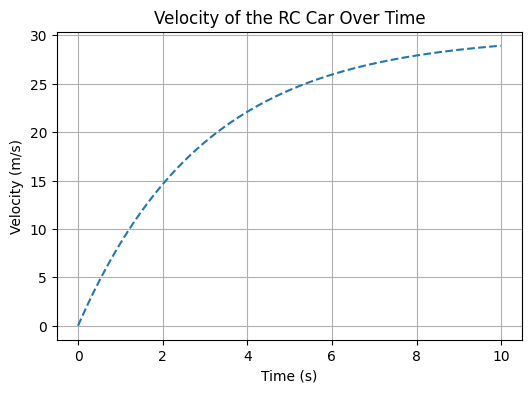

In [32]:
# Car arameters
m = 1.5  # mass of the car (kg)
b = 0.5  # friction coefficient (N·s/m)

# motor command
F_motor = 15.0  # constant motor force (N)

# simulation parameters
dt = 0.01  # time step (s)
t_max = 10.0  # maximum simulation time (s)
# Time array
t = np.arange(0, t_max, dt)

# Velocity array
v = np.zeros_like(t)
# Initial condition
v[0] = 0.0  # initial velocity (m/s)


# Numerical simulation (Euler's method)
for i in range(1, len(t)):
    # Simplified model (without air resistance)
    dv_simplified = (F_motor/m - (b/m) * v[i-1]) * dt
    v[i] = v[i-1] + dv_simplified

# Plotting the results
plt.figure(figsize=(6, 4))
plt.plot(t, v, linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity of the RC Car Over Time')
plt.grid(True)
plt.show()
    

### Calibrating the Velocity Model

In this section, you will determine the parameters $F_\text{motor}$ and $b$. The mass of the car is given as $m=5.6 kg$. To find these parameters, we will closely examine the velocity equation and write some code to make measurements on the car. This part is less guided so you will have to find some of your own sollutions. Remember that the velocity equation is:

$$ v(t) = \frac{F_{\text{motor}}}{b} \left(1 - e^{-\frac{b}{m}t}\right) $$

With its derivative:

$$ \frac{dv}{dt} = \frac{F_{\text{motor}}}{m}  \times e^{-\frac{b}{m}t}$$

#### Finding the Friction Coefficient b

1. **Measure Terminal Velocity:**
   - Run the car at a motor command setting of interest towards a wall. Measure the terminal velocity as the car accelerates until v_terminal is reached. Please place one of the boxes in front of the car to stop it from crashing into the wall. Transfor these distance measurements into a velocity plot.
   
2. **Initial Acceleration:**
   - At the very beginning of the motion, the car starts from rest, and the initial velocity v(0) = 0. At this point, frictional forces are negligible since v is small, and the acceleration dv\dt can be approximated by:
     $$ \frac{dv}{dt} \approx \frac{F_{\text{motor}}}{m} $$
   - Measure the acceleration of the car from rest. This can be done by measuring the speed at two very close time intervals after the car starts moving and calculating the acceleration using the formula:
     $$ a_0 = \frac{\Delta v}{\Delta t} $$

3. **Calculate F_motor:**
   - Use the measured initial acceleration a_0 to calculate the motor force:
     $$ F_{\text{motor}} = m \times a_0 $$

4. **Calculate b Using Terminal Velocity:**
   - With F_motor known, use the measured terminal velocity v_terminal to calculate the friction coefficient b:
     $$ b = \frac{F_{\text{motor}}}{v_{\text{terminal}}} $$

---

## Ackermann Steering Model

The Ackermann steering model provides a simplified yet effective method for understanding and implementing the steering mechanism of a vehicle with four wheels. This chapter explores the Ackermann steering geometry, its derivation, and how it can be applied in both physical and computational models for KITT.

### The Ackermann Steering Geometry

#### Overview

The Ackermann steering geometry is a geometric arrangement of linkages in the steering of a vehicle designed to turn the inner and outer wheels at appropriate angles during a turn. The purpose of this setup is to ensure that all wheels are pointing toward a common center of rotation, minimizing tire slip and improving handling during turns. (@Mano % Add image here)

#### Steering Angles

In a car with Ackermann steering, the inner wheel turns at a greater angle than the outer wheel. This difference in angles is necessary because, during a turn, the inner wheel follows a smaller radius path than the outer wheel.

Consider a vehicle with a wheelbase L (distance between the front and rear axles) and a track width W (distance between the left and right wheels). The steering angles $\theta_{\text{inner}}$ and $\theta_{\text{outer}}$ can be defined as follows: 

- $\theta_{\text{inner}}$: The angle of the inner front wheel relative to the vehicle's longitudinal axis.
- $\theta_{\text{outer}}$: The angle of the outer front wheel relative to the vehicle's longitudinal axis.

#### Geometric Derivation

The Ackermann steering geometry is derived based on the concept that all four wheels should ideally follow circular paths with a common center of rotation during a turn. Consider the following derivation:

Let $R$ be the distance from the center of rotation to the midpoint of the rear axle (the turning radius), and $r_\text{inner}$ and $r_\text{outer}$ be the radii of the paths of the inner and outer wheels, respectively.

From geometry:

$$ \text{tan}(\theta_{\text{inner}}) = \frac{L}{R - \frac{W}{2}} $$

$$ \text{tan}(\theta_{\text{outer}}) = \frac{L}{R + \frac{W}{2}} $$

Given that:

$$ \text{tan}(\theta_{\text{outer}}) = \frac{\text{tan}(\theta_{\text{inner}}) \cdot (R + \frac{W}{2})}{R - \frac{W}{2}} $$

Thus, the relationship between the inner and outer steering angles can be approximated as: (@Mano this is not a relation between the inner and outer! something seems to be missing)

$$ \theta_{\text{outer}} \approx \arctan\left(\frac{L}{R + \frac{W}{2}}\right) $$

This model assumes that the wheels are free to pivot without slipping, which is a reasonable approximation for low-speed maneuvers.

In [33]:
# Car Parameters
L = 0.3  # Wheelbase (meters)
W = 0.2  # Track width (meters)
R = 1.0  # Desired turning radius (meters)

# Calculate inner and outer steering angles using Ackermann geometry
theta_inner = np.arctan(L / (R - W / 2))
theta_outer = np.arctan(L / (R + W / 2))

# Convert to degrees for easier interpretation
theta_inner_deg = np.degrees(theta_inner)
theta_outer_deg = np.degrees(theta_outer)

print(f"Inner Steering Angle: {theta_inner_deg:.2f} degrees")
print(f"Outer Steering Angle: {theta_outer_deg:.2f} degrees")

Inner Steering Angle: 18.43 degrees
Outer Steering Angle: 15.26 degrees


### Limitations of Ackermann Steering

The Ackermann model is most accurate at low speeds and when the car's tires maintain good contact with the road. At higher speeds or in dynamic driving situations, more advanced models (such as the bicycle model) or empirical tuning may be required to achieve desired handling characteristics.

---

## Building a Unified Car Model

### Introduction

In this chapter, you will learn how to integrate the velocity model and the Ackermann steering model into a single, unified Python class.

### Step 1: Setting Up the Car’s Physical Properties

To begin, we need to define the physical properties of KITT. These include its mass, wheelbase, track width, friction coefficient, air resistance coefficient, and maximum motor force. These properties will be used in our calculations.

In [34]:
# Step 1: Define the physical properties of the RC car
mass = 5.6  # kg, mass of the car
wheelbase = 0.3  # m, distance between the front and rear axles
track_width = 0.2  # m, distance between the left and right wheels
friction_coefficient = 3.2  # N·s/m, resistance due to friction
air_resistance_coefficient = 0.1  # N·s^2/m^2, resistance due to air drag
max_motor_force = 4.0  # N, maximum force generated by the motor

### Step 2: Initializing the Car’s State

Next, we need to initialize the state of the car. The state includes the car’s position, velocity, orientation, and the current time. We will store the position as a 2D coordinate (x, y), the velocity as a scalar (speed in meters per second), the orientation as an angle (in radians), and time as a scalar (in seconds).

In [35]:
# Step 2: Initialize the car's state
position = np.array([0.0, 0.0])  # (x, y) position in meters
velocity = 0.0  # initial speed in m/s
orientation = 0.0  # initial orientation in radians (0 means facing along the x-axis)
time = 0.0  # start time in seconds

### Step 3: Updating the Car’s Velocity

KITT's velocity depends on the force applied by the motor, as well as the friction and air resistance. You have already derived the equation for updating the velocity:

$$ \text{acceleration} = \frac{F_{\text{motor}}}{m} - \frac{b}{m} v - \frac{c}{m} v^2 $$

We can now implement this equation as a function in Python:

In [36]:
# Step 3: Define a function to update the car's velocity
def update_velocity(velocity, F_motor, mass, friction_coefficient, air_resistance_coefficient, dt):
    # Calculate acceleration
    acceleration = (F_motor / mass) - (friction_coefficient / mass) * velocity - (air_resistance_coefficient / mass) * velocity**2
    # Update velocity
    velocity += acceleration * dt
    return velocity


### Step 4: Updating the Car’s Orientation

The car’s orientation changes based on the turn radius. The Ackermann steering model helps us determine how much the car’s orientation should change given the current velocity and turning radius.

The change in orientation can be calculated as:

$$ \text{change in orientation} = \frac{\text{velocity}}{\text{turn radius}} \times \Delta t $$

In [37]:
# Step 4: Define a function to update the car's orientation
def update_orientation(orientation, velocity, turn_radius, dt):
    if turn_radius != 0:
        orientation_change = (velocity / turn_radius) * dt
    else:
        orientation_change = 0
    orientation += orientation_change
    return orientation

### Step 5: Updating the Car’s Position

The car’s position changes based on its velocity and orientation. We can use basic trigonometry to update the position:


$$ \text{new position} = \text{current position} + \text{velocity} \times \Delta t \times (\cos(\text{orientation}), \sin(\text{orientation})) $$

In [38]:
# Step 5: Define a function to update the car's position
def update_position(position, velocity, orientation, dt):
    position[0] += velocity * np.cos(orientation) * dt  # Update x-coordinate
    position[1] += velocity * np.sin(orientation) * dt  # Update y-coordinate
    return position

### Step 6: Integrating Everything into a Car Class

Now that you have functions to update each part of the car’s state, it’s convenient to integrate everything into a single class. This class will manage the car’s state and provide an easy interface to simulate its movement.

In [39]:
# Step 6: Create the KITT_Dynamics class
class KITT_Dynamics:
    def __init__(self, mass, wheelbase, track_width, friction_coefficient, air_resistance_coefficient, max_motor_force):
        # Physical properties of the car
        self.mass = mass
        self.wheelbase = wheelbase
        self.track_width = track_width
        self.friction_coefficient = friction_coefficient
        self.air_resistance_coefficient = air_resistance_coefficient
        self.max_motor_force = max_motor_force
        
        # Initial state
        self.position = np.array([0.0, 0.0])  # (x, y) position
        self.velocity = 0.0  # initial velocity in m/s
        self.orientation = 0.0  # initial orientation in radians
        self.time = 0.0  # start time in seconds
        
    def update(self, motor_on, turn_radius, dt):
        # Determine the motor force
        F_motor = self.max_motor_force if motor_on else 0.0
        
        # Update the car's state
        self.velocity = update_velocity(self.velocity, F_motor, self.mass, self.friction_coefficient, self.air_resistance_coefficient, dt)
        self.orientation = update_orientation(self.orientation, self.velocity, turn_radius, dt)
        self.position = update_position(self.position, self.velocity, self.orientation, dt)
        
        # Update time
        self.time += dt
    
    def get_state(self):
        return {
            'position': self.position,
            'velocity': self.velocity,
            'orientation': self.orientation,
            'time': self.time
        }

### Step 7: Running the Simulation

With the car model complete, you can now simulate the car’s movement over time. We do this by computing the position of the car in steps of dt, storing the positions in an array, and finally plotting them.

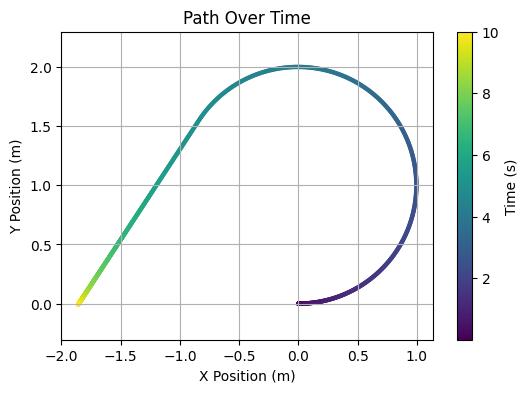

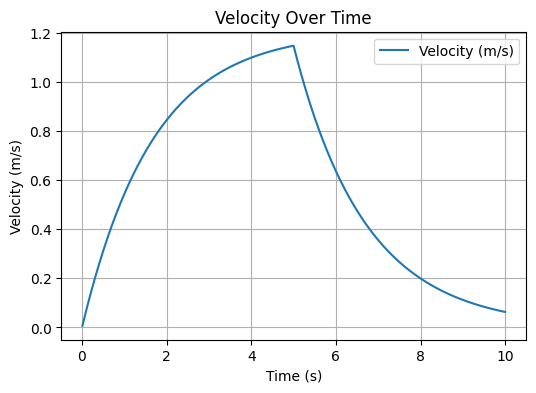

In [40]:
# Step 7: Simulate the car's motion
dt = 0.01  # time step (s)
simulation_time = 10.0  # total simulation time (s)
turn_radius = 1.0  # turn radius in meters (positive for right, negative for left)

# Initialize the car model
car = KITT_Dynamics(mass, wheelbase, track_width, friction_coefficient, air_resistance_coefficient, max_motor_force)

# Arrays to store the simulation data
positions = []
velocities = []
orientations = []
times = []

# Run the simulation
for t in np.arange(0, simulation_time, dt):
    if t < 5.0:
        car.update(motor_on=True, turn_radius=turn_radius, dt=dt)
    else:
        car.update(motor_on=False, turn_radius=0, dt=dt)
    state = car.get_state()
    
    positions.append(state['position'].copy())
    velocities.append(state['velocity'])
    orientations.append(state['orientation'])
    times.append(state['time'])
    
# Convert to numpy arrays for easier plotting
positions = np.array(positions)
velocities = np.array(velocities)
orientations = np.array(orientations)
times = np.array(times)

# Plotting the car's path with color gradient based on time
plt.figure(figsize=(6, 4))
sc = plt.scatter(positions[:, 0], positions[:, 1], c=times, cmap='viridis', label="Car Path", s=5)
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("Path Over Time")
plt.axis('equal')
plt.grid(True)
plt.colorbar(sc, label="Time (s)")
plt.show()

# Plotting the car's velocity over time
plt.figure(figsize=(6, 4))
plt.plot(times, velocities, label="Velocity (m/s)")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Over Time")
plt.grid(True)
plt.legend()
plt.show()

## Mid-term assessment and report

In the midterm assessment, the TA will give you a short series of driving/steering commands (e.g., M165,
D150 for 0.5 sec, D170 for 0.5 sec, stop), your model predicts the position, and this is compared to the
actual position of KITT after following the same series of commands.
In the midterm report, present the model, and present test results that shows the accuracy of this model,
starting from a known state. Summarize in a conclusion: over what time period can you predict the new
position of the car with an accuracy better than 30 cm?

## After the Midterm: GUI integration 

(@Mano, how should we update this now? they don't need to make a GUI but they can work on the controller)
After the midterm, you will work on a controller that takes you from A to B. Part of this is to have a GUI
where you show the field and the measured position of the car.
If you have a good car model, you can develop the controller and test it on this model. You can show the
resulting estimated positions of the car in the GUI. This is convenient for debugging, since your testing
time on the real field is very limited.
If your model is reliable, then at a later stage you can try to fuse location estimates from the beacon
signals with location predictions from the model. For optimal fusion, you need to know the accuracy
(variance) of each of the estimates, so you can take a weighted average. You can also use the model
predictions to detect and reject possible outliers from the beacon method.
You will probably find that the car behavior is not constant; e.g., the velocity response depends on the
battery status and also (slightly) on the steering setting. You could extend your model to take that into
account.
Further, to make the virtual model interface similar to the actual car interface, you would have to integrate
the Module 3 Localization scripts in such a way in the class KITT that you can request the current state
(position, orientation) from the real car just as you request it from the virtual model.